# Emotion Detection - JAFFE

Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-using-transfer)

## Library Preparation

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import losses, optimizers, metrics

## Data Processing

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Create the main 'data' directory
if not os.path.exists('/kaggle/working/data'):
    os.makedirs('/kaggle/working/data')

# Create 'train' and 'test' subdirectories
if not os.path.exists('/kaggle/working/data/train'):
    os.makedirs('/kaggle/working/data/train')
if not os.path.exists('/kaggle/working/data/test'):
    os.makedirs('/kaggle/working/data/test')

# Define the source directory
source_dir = '/kaggle/input/jaffe-dataset/jaffe/jaffe'

# Define the emotion labels
emotions = ['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE']

# Create directories for each emotion within 'train' and 'test'
for emotion in emotions:
    if not os.path.exists(f'data/train/{emotion}'):
        os.makedirs(f'data/train/{emotion}')
    if not os.path.exists(f'data/test/{emotion}'):
        os.makedirs(f'data/test/{emotion}')

# List all files in the source directory
all_files = os.listdir(source_dir)

# Group files by emotion and store split files
emotion_split_files = {}
for filename in all_files:
    parts = filename.split('.')
    if len(parts) > 1:
        # The emotion seems to be the second part before the number
        # Adjust this logic if the naming convention is different
        emotion_code = parts[1][:-1] # Remove the trailing digit (e.g., 'AN1' -> 'AN')
        if emotion_code in emotions:
            if emotion_code not in emotion_split_files:
                emotion_split_files[emotion_code] = []
            emotion_split_files[emotion_code].append(filename)

# Split and copy files for each emotion
train_counts = {}
test_counts = {}
for emotion, files in emotion_split_files.items():
    if not files:
        print(f"No files found for emotion: {emotion}")
        continue

    # Split files into training and testing sets
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    train_counts[emotion] = len(train_files)
    test_counts[emotion] = len(test_files)

    # Copy training files
    for file in train_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('/kaggle/working/data/train', emotion, file)
        shutil.copy2(src_path, dest_path) # Use copy2 to preserve metadata

    # Copy testing files
    for file in test_files:
        src_path = os.path.join(source_dir, file)
        dest_path = os.path.join('/kaggle/working/data/test', emotion, file)
        shutil.copy2(src_path, dest_path)

print("Data splitting and organization complete.")
print(f"Train images per emotion: {train_counts}")
print(f"Test images per emotion: {test_counts}")

Data splitting and organization complete.
Train images per emotion: {'SA': 24, 'DI': 23, 'AN': 24, 'HA': 24, 'FE': 25, 'NE': 24, 'SU': 24}
Test images per emotion: {'SA': 7, 'DI': 6, 'AN': 6, 'HA': 7, 'FE': 7, 'NE': 6, 'SU': 6}


In [5]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

train_dir = '/kaggle/working/data/train'
test_dir ='/kaggle/working/data/test'

img_height = 224
img_width = 224
batch_size = 32

# Function to load images as NumPy arrays
def load_images_from_directory(directory, image_size=(img_height, img_width)):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    label_map = {name: index for index, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
                img_array = keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

# Load training and validation data
train_images, train_labels, class_names = load_images_from_directory(train_dir)
validation_images, validation_labels, _ = load_images_from_directory(test_dir)

# Convert labels to categorical
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=len(class_names))
validation_labels_one_hot = keras.utils.to_categorical(validation_labels, num_classes=len(class_names))

# Create TensorFlow datasets
train_generator = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot)).batch(batch_size).shuffle(buffer_size=100)
validation_generator = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels_one_hot)).batch(batch_size)

print("Data generators created successfully.")

Data generators created successfully.


I0000 00:00:1749818457.526823      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749818457.527549      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(32, 224, 224, 3)


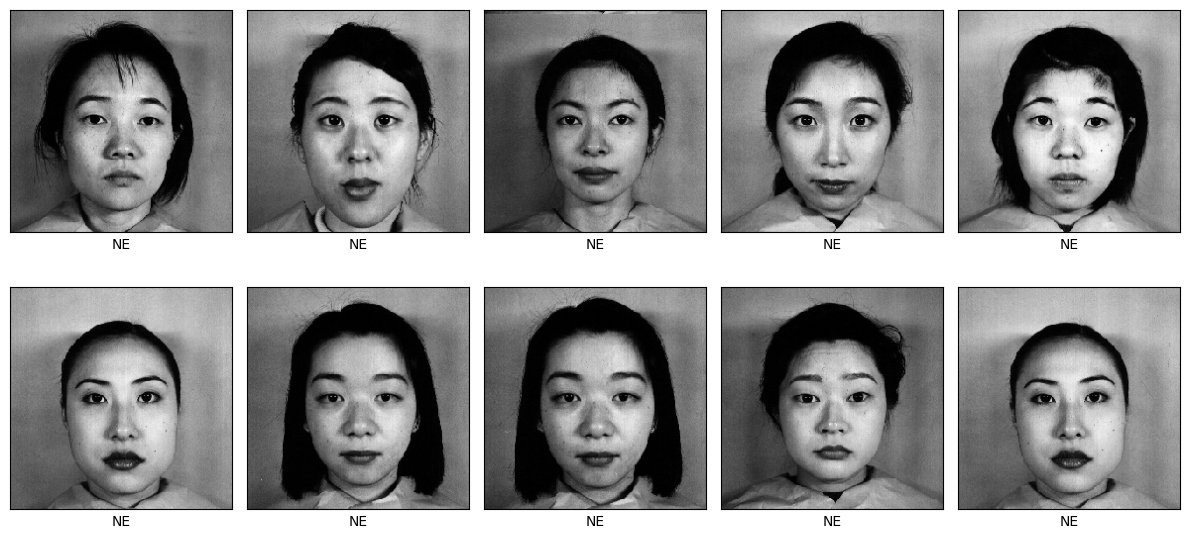

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Import tensorflow

# Assuming 'train_generator' is available from your previous code setup
classes = {i: name for i, name in enumerate(class_names)}


# Use the 'train_generator' to get a batch
for images, cls_true_one_hot in train_generator.take(1): # Take one batch
    print(images.shape)
    # images and labels are already TensorFlow tensors

    # Convert one-hot encoded labels back to integer labels
    cls_true = tf.argmax(cls_true_one_hot, axis=1).numpy() # Convert to numpy array

    break # Get only the first batch for display

fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Added figsize for better display
axes = axes.flatten() # Flatten the 2x5 array of axes for easier iteration

# Get the number of images in the batch
num_images_in_batch = images.shape[0]

for i, ax in enumerate(axes): # Using 'ax' directly from flattened axes
    if i < num_images_in_batch: # Only display if there is an image in the batch
        # Plot image.
        # TensorFlow images are typically float [0, 255] or [0, 1]. Assuming [0, 255] from load_img
        img_display = images[i].numpy().astype(np.uint8) # Convert tensor to NumPy array (H, W, C) and to uint8

        ax.imshow(img_display)

        # Show true class.
        true_label_idx = cls_true[i] # Get the integer label

        # Use the 'classes' dictionary for mapping numerical label to string name
        xlabel = classes[true_label_idx]

        # Set the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Hide unused subplots
        ax.axis('off')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [7]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299), # Changed from 224 to 299
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299), # Changed from 256 to 299 (keeping aspect ratio before center crop)
        transforms.CenterCrop(299), # Changed from 224 to 299
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Model Development

In [8]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, i=0, dataloaders=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if isinstance(outputs, tuple):
                        outputs=outputs[0]

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/inception_'+str(i)+'.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning /w Covnet

Load a pretrained model and reset final fully connected layer.

In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class JAFFEDataset(Dataset):
    def __init__(self, root_dir, transform=None, idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = [] # Assuming you have a way to get labels from filenames or a manifest

        # This is a simplified example; adjust based on your actual JAFFE dataset structure.
        emotion_map = {'AN': 0, 'DI': 1, 'FE': 2, 'HA': 3, 'NE': 4, 'SA': 5, 'SU': 6} # Map emotion codes to integers

        for filename in os.listdir(root_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                # Example parsing: Assuming format like 'Subj.EmotionCode.Num.ext'
                # You might need to adjust this based on your exact JAFFE file names
                parts = filename.split('.')
                if len(parts) > 1:
                    emotion_code_with_num = parts[1] # e.g., 'AN1', 'HA3'
                    emotion_code = emotion_code_with_num[:-1] # e.g., 'AN', 'HA'

                    if emotion_code in emotion_map:
                        self.image_files.append(os.path.join(root_dir, filename))
                        self.labels.append(emotion_map[emotion_code])

        if idx is not None:
            self.image_files = [self.image_files[i] for i in idx]
            self.labels = [self.labels[i] for i in idx]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB') # Ensure image is in RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
import numpy as np
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import os # Import os module

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the directory for saving models if it doesn't exist
if not os.path.exists('saved'):
    os.makedirs('saved')

dataset_sizes = {'train': len(train_images), 'val': len(validation_images)} # Using lengths from the loaded numpy arrays

accuracies = []
index = list(np.random.permutation(len(train_images) + len(validation_images))) # Use the total number of images

for i in range(10): # Assuming 10 folds
    fold_size = len(index) // 10 # Determine fold size

    # Correctly split index for train and val sets for each fold
    val_indices = index[i * fold_size:(i + 1) * fold_size]
    # Handle the last fold which might be slightly larger
    if i == 9:
        val_indices = index[i * fold_size:]

    train_indices = [idx for idx in index if idx not in val_indices]

    idx = {'val': val_indices, 'train': train_indices}

    dataloaders = {x: torch.utils.data.DataLoader(JAFFEDataset(root_dir='/kaggle/input/jaffe-dataset/jaffe/jaffe', transform=data_transforms[x], idx=idx[x]), batch_size=16,
                                             shuffle=True)
              for x in ['train', 'val']}


    # Recalculate dataset_sizes for the current fold
    dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

    model_ft = models.inception_v3(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # Assuming class_names is defined

    # InceptionV3 also has an auxiliary classifier
    num_aux_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_aux_ftrs, len(class_names))

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)
    writer = SummaryWriter('./logs/inception_full') # Consider adding fold index to log path
    model_ft, best_acc  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, i, dataloaders,
                           num_epochs=20)
    # Assuming best_acc is a tensor, convert it to a Python float
    accuracies.append(float(best_acc.cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

# After the loop, you can calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"\nAverage accuracy across 10 folds: {average_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 203MB/s]  
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch

Epoch 0/19
----------


100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


train Loss: 2.1100 Acc: 0.1250


100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


val Loss: 1.6478 Acc: 0.4286

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


train Loss: 2.0247 Acc: 0.2188


100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


val Loss: 3.4609 Acc: 0.0476

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


train Loss: 1.6870 Acc: 0.3385


100%|██████████| 2/2 [00:00<00:00, 12.24it/s]


val Loss: 2.0388 Acc: 0.3333

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


train Loss: 1.3176 Acc: 0.5000


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


val Loss: 1.1201 Acc: 0.5714

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


train Loss: 1.1702 Acc: 0.5469


100%|██████████| 2/2 [00:00<00:00, 12.08it/s]


val Loss: 0.5309 Acc: 0.9048

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


train Loss: 0.9979 Acc: 0.6250


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


val Loss: 0.5446 Acc: 0.8571

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


train Loss: 0.9281 Acc: 0.6771


100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


val Loss: 0.5495 Acc: 0.8571

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.56it/s]


train Loss: 0.9400 Acc: 0.6458


100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


val Loss: 0.5260 Acc: 0.8571

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


train Loss: 0.9058 Acc: 0.6719


100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


val Loss: 0.4896 Acc: 0.8571

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


train Loss: 0.9239 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 12.11it/s]


val Loss: 0.4668 Acc: 0.8571

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.62it/s]


train Loss: 0.7623 Acc: 0.7396


100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


val Loss: 0.4874 Acc: 0.8571

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


train Loss: 0.9557 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.77it/s]


val Loss: 0.4957 Acc: 0.8571

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


train Loss: 0.9060 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


val Loss: 0.4809 Acc: 0.8571

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


train Loss: 0.9409 Acc: 0.6458


100%|██████████| 2/2 [00:00<00:00, 12.19it/s]


val Loss: 0.4806 Acc: 0.8571

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.56it/s]


train Loss: 0.8527 Acc: 0.7188


100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


val Loss: 0.4741 Acc: 0.8571

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


train Loss: 0.7970 Acc: 0.7135


100%|██████████| 2/2 [00:00<00:00, 12.06it/s]


val Loss: 0.4814 Acc: 0.8571

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.59it/s]


train Loss: 0.8133 Acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 12.03it/s]


val Loss: 0.4836 Acc: 0.8571

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


train Loss: 0.9866 Acc: 0.6458


100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


val Loss: 0.4840 Acc: 0.8571

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 0.9276 Acc: 0.6771


100%|██████████| 2/2 [00:00<00:00, 11.89it/s]


val Loss: 0.4834 Acc: 0.8571

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


train Loss: 0.8920 Acc: 0.6510


100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


val Loss: 0.4758 Acc: 0.8571

Training complete in 1m 14s
Best val Acc: 0.904762



------------------------------------
 Accuracies  [0.9047619047619047]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


train Loss: 2.1870 Acc: 0.1198


100%|██████████| 2/2 [00:00<00:00, 11.99it/s]


val Loss: 1.9069 Acc: 0.2381

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


train Loss: 2.0741 Acc: 0.2188


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


val Loss: 1.8489 Acc: 0.2381

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


train Loss: 1.9176 Acc: 0.3073


100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


val Loss: 2.5378 Acc: 0.2381

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


train Loss: 1.5680 Acc: 0.4062


100%|██████████| 2/2 [00:00<00:00, 11.62it/s]


val Loss: 1.7641 Acc: 0.4286

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.52it/s]


train Loss: 1.4543 Acc: 0.4115


100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


val Loss: 1.1942 Acc: 0.5714

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


train Loss: 1.3247 Acc: 0.4740


100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


val Loss: 1.2009 Acc: 0.5238

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.48it/s]


train Loss: 1.2336 Acc: 0.5573


100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


val Loss: 0.9991 Acc: 0.6667

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


train Loss: 1.1371 Acc: 0.6510


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


val Loss: 0.8955 Acc: 0.7143

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.1620 Acc: 0.5469


100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


val Loss: 0.9106 Acc: 0.6667

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


train Loss: 1.1219 Acc: 0.5833


100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


val Loss: 0.8532 Acc: 0.6667

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


train Loss: 1.0805 Acc: 0.5781


100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


val Loss: 0.8602 Acc: 0.6190

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


train Loss: 1.1198 Acc: 0.5729


100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


val Loss: 0.8369 Acc: 0.6667

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


train Loss: 1.0400 Acc: 0.5938


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


val Loss: 0.8344 Acc: 0.6667

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


train Loss: 1.1375 Acc: 0.5781


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


val Loss: 0.8723 Acc: 0.6190

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


train Loss: 1.1004 Acc: 0.5573


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


val Loss: 0.8594 Acc: 0.6190

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.0963 Acc: 0.6302


100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


val Loss: 0.8302 Acc: 0.6667

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 1.0201 Acc: 0.6094


100%|██████████| 2/2 [00:00<00:00, 11.11it/s]


val Loss: 0.8359 Acc: 0.6667

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 1.0735 Acc: 0.5625


100%|██████████| 2/2 [00:00<00:00, 12.00it/s]


val Loss: 0.8530 Acc: 0.6667

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 1.0469 Acc: 0.6562


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


val Loss: 0.8605 Acc: 0.6190

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 1.2013 Acc: 0.5677


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


val Loss: 0.8613 Acc: 0.6190

Training complete in 1m 14s
Best val Acc: 0.714286



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 2.1381 Acc: 0.1354


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


val Loss: 1.8864 Acc: 0.1905

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


train Loss: 1.9253 Acc: 0.3333


100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


val Loss: 1.8209 Acc: 0.2857

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 1.4870 Acc: 0.4323


100%|██████████| 2/2 [00:00<00:00, 11.76it/s]


val Loss: 3.4052 Acc: 0.0476

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 1.3815 Acc: 0.4896


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


val Loss: 1.5165 Acc: 0.3333

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 1.1269 Acc: 0.5729


100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


val Loss: 1.1461 Acc: 0.5714

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.0056 Acc: 0.6198


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


val Loss: 0.7108 Acc: 0.7619

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.9558 Acc: 0.6302


100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


val Loss: 0.5602 Acc: 0.7619

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.48it/s]


train Loss: 0.8618 Acc: 0.6562


100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


val Loss: 0.5569 Acc: 0.8095

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.48it/s]


train Loss: 0.8367 Acc: 0.7135


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


val Loss: 0.5946 Acc: 0.7619

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


train Loss: 0.7964 Acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 11.81it/s]


val Loss: 0.5896 Acc: 0.7619

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 0.7803 Acc: 0.7344


100%|██████████| 2/2 [00:00<00:00, 10.85it/s]


val Loss: 0.5608 Acc: 0.8095

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 0.8874 Acc: 0.7031


100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


val Loss: 0.5501 Acc: 0.7619

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.8408 Acc: 0.7083


100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


val Loss: 0.5884 Acc: 0.7619

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.7564 Acc: 0.7188


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


val Loss: 0.5497 Acc: 0.8095

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


train Loss: 0.7620 Acc: 0.7188


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


val Loss: 0.5820 Acc: 0.8095

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8258 Acc: 0.7135


100%|██████████| 2/2 [00:00<00:00, 10.75it/s]


val Loss: 0.5872 Acc: 0.8095

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8065 Acc: 0.6979


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


val Loss: 0.5933 Acc: 0.7619

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 0.7911 Acc: 0.7396


100%|██████████| 2/2 [00:00<00:00, 11.65it/s]


val Loss: 0.5918 Acc: 0.7143

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.7398 Acc: 0.7552


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


val Loss: 0.5903 Acc: 0.7619

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.9050 Acc: 0.6771


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


val Loss: 0.5771 Acc: 0.7619

Training complete in 1m 16s
Best val Acc: 0.809524



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.34it/s]


train Loss: 2.0594 Acc: 0.1458


100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


val Loss: 2.0151 Acc: 0.1905

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 1.9445 Acc: 0.2135


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


val Loss: 2.7821 Acc: 0.0952

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.7146 Acc: 0.3229


100%|██████████| 2/2 [00:00<00:00, 11.71it/s]


val Loss: 1.9110 Acc: 0.1429

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 1.3734 Acc: 0.4531


100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


val Loss: 1.5247 Acc: 0.3333

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 1.1806 Acc: 0.5833


100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


val Loss: 1.2048 Acc: 0.5238

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 1.1099 Acc: 0.5781


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


val Loss: 1.1396 Acc: 0.4762

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


train Loss: 1.0435 Acc: 0.6406


100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


val Loss: 0.9540 Acc: 0.6667

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.9606 Acc: 0.6719


100%|██████████| 2/2 [00:00<00:00, 11.66it/s]


val Loss: 0.9281 Acc: 0.6667

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.8203 Acc: 0.7396


100%|██████████| 2/2 [00:00<00:00, 11.61it/s]


val Loss: 0.9020 Acc: 0.6667

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.8581 Acc: 0.7188


100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


val Loss: 0.8887 Acc: 0.6667

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.8975 Acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


val Loss: 0.8894 Acc: 0.6667

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 0.8763 Acc: 0.7031


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


val Loss: 0.8869 Acc: 0.7143

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 0.7797 Acc: 0.7448


100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


val Loss: 0.8859 Acc: 0.6667

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.8720 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


val Loss: 0.8756 Acc: 0.6667

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9328 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


val Loss: 0.8836 Acc: 0.6667

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.9243 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


val Loss: 0.9046 Acc: 0.7143

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


train Loss: 0.8620 Acc: 0.6771


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


val Loss: 0.8825 Acc: 0.6667

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.8955 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


val Loss: 0.8973 Acc: 0.6667

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


train Loss: 0.8878 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.57it/s]


val Loss: 0.8742 Acc: 0.6667

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.8443 Acc: 0.7240


100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


val Loss: 0.8616 Acc: 0.6667

Training complete in 1m 16s
Best val Acc: 0.714286



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


train Loss: 2.0457 Acc: 0.1719


100%|██████████| 2/2 [00:00<00:00, 11.85it/s]


val Loss: 2.0452 Acc: 0.3333

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


train Loss: 1.8510 Acc: 0.2917


100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


val Loss: 1.8544 Acc: 0.2857

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.5801 Acc: 0.4062


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


val Loss: 1.9913 Acc: 0.2857

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 1.2583 Acc: 0.5156


100%|██████████| 2/2 [00:00<00:00, 11.70it/s]


val Loss: 1.2778 Acc: 0.6190

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


train Loss: 1.2105 Acc: 0.5781


100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


val Loss: 1.2766 Acc: 0.5714

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 1.1068 Acc: 0.5833


100%|██████████| 2/2 [00:00<00:00, 11.61it/s]


val Loss: 1.3703 Acc: 0.5714

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.9463 Acc: 0.6198


100%|██████████| 2/2 [00:00<00:00, 11.52it/s]


val Loss: 1.2582 Acc: 0.6190

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.9084 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


val Loss: 1.2225 Acc: 0.6190

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 0.8590 Acc: 0.6667


100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


val Loss: 1.2667 Acc: 0.6190

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 0.8364 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.11it/s]


val Loss: 1.1686 Acc: 0.6667

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.7112 Acc: 0.7188


100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


val Loss: 1.1683 Acc: 0.6190

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


train Loss: 0.8232 Acc: 0.6771


100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


val Loss: 1.2401 Acc: 0.6190

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.8078 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


val Loss: 1.2516 Acc: 0.6190

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.9633 Acc: 0.6198


100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


val Loss: 1.2067 Acc: 0.6190

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.8091 Acc: 0.7500


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


val Loss: 1.2036 Acc: 0.6190

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


train Loss: 0.8749 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.57it/s]


val Loss: 1.2350 Acc: 0.6190

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8056 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 10.96it/s]


val Loss: 1.1834 Acc: 0.6190

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.7968 Acc: 0.7344


100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


val Loss: 1.1987 Acc: 0.6190

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.34it/s]


train Loss: 0.7448 Acc: 0.7292


100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


val Loss: 1.1951 Acc: 0.6190

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8713 Acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 11.82it/s]


val Loss: 1.2103 Acc: 0.6190

Training complete in 1m 16s
Best val Acc: 0.666667



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142, 0.6666666666666666]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


train Loss: 2.0793 Acc: 0.1458


100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


val Loss: 1.9171 Acc: 0.1905

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]


train Loss: 2.0011 Acc: 0.2292


100%|██████████| 2/2 [00:00<00:00, 11.60it/s]


val Loss: 1.7925 Acc: 0.4286

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


train Loss: 1.7784 Acc: 0.3646


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


val Loss: 1.7771 Acc: 0.2857

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


train Loss: 1.4383 Acc: 0.4427


100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


val Loss: 1.0837 Acc: 0.5238

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 1.2425 Acc: 0.5052


100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


val Loss: 1.0078 Acc: 0.6667

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 1.0890 Acc: 0.5625


100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


val Loss: 1.0447 Acc: 0.4762

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9573 Acc: 0.6146


100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


val Loss: 0.7985 Acc: 0.6667

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.9310 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


val Loss: 0.7690 Acc: 0.7143

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.9051 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


val Loss: 0.7748 Acc: 0.7143

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8517 Acc: 0.7135


100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


val Loss: 0.7596 Acc: 0.8095

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9008 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


val Loss: 0.7271 Acc: 0.7619

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.9502 Acc: 0.6458


100%|██████████| 2/2 [00:00<00:00, 11.83it/s]


val Loss: 0.7249 Acc: 0.7619

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.8829 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 10.90it/s]


val Loss: 0.7255 Acc: 0.8095

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.8459 Acc: 0.7031


100%|██████████| 2/2 [00:00<00:00, 11.84it/s]


val Loss: 0.6841 Acc: 0.7619

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


train Loss: 0.7904 Acc: 0.7500


100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


val Loss: 0.7251 Acc: 0.7619

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.9897 Acc: 0.6406


100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


val Loss: 0.6933 Acc: 0.7619

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.9260 Acc: 0.6667


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


val Loss: 0.7218 Acc: 0.8095

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


train Loss: 0.9178 Acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


val Loss: 0.7336 Acc: 0.7619

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.9237 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.83it/s]


val Loss: 0.7144 Acc: 0.7619

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


train Loss: 0.8776 Acc: 0.7031


100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


val Loss: 0.7214 Acc: 0.8095

Training complete in 1m 17s
Best val Acc: 0.809524



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142, 0.6666666666666666, 0.8095238095238095]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 2.0892 Acc: 0.1354


100%|██████████| 2/2 [00:00<00:00, 11.76it/s]


val Loss: 2.1698 Acc: 0.2381

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 1.9147 Acc: 0.2708


100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


val Loss: 1.6547 Acc: 0.3333

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 1.6382 Acc: 0.3958


100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


val Loss: 2.9951 Acc: 0.1429

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.4800 Acc: 0.4427


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


val Loss: 1.7318 Acc: 0.3810

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 1.1772 Acc: 0.5365


100%|██████████| 2/2 [00:00<00:00, 12.00it/s]


val Loss: 1.3571 Acc: 0.4286

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 1.0791 Acc: 0.5990


100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


val Loss: 1.1857 Acc: 0.5714

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.0197 Acc: 0.5990


100%|██████████| 2/2 [00:00<00:00, 10.93it/s]


val Loss: 1.3212 Acc: 0.5238

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9635 Acc: 0.6302


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


val Loss: 1.2736 Acc: 0.5238

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 1.0516 Acc: 0.5885


100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


val Loss: 1.2391 Acc: 0.5238

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 0.9059 Acc: 0.6354


100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


val Loss: 1.1532 Acc: 0.5714

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.8972 Acc: 0.6510


100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


val Loss: 1.1841 Acc: 0.5238

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.9564 Acc: 0.6406


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


val Loss: 1.1587 Acc: 0.5238

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.9524 Acc: 0.6198


100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


val Loss: 1.1931 Acc: 0.5238

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.9543 Acc: 0.6094


100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


val Loss: 1.1801 Acc: 0.5238

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]


train Loss: 0.8813 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


val Loss: 1.1784 Acc: 0.5714

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 1.0009 Acc: 0.6302


100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


val Loss: 1.1662 Acc: 0.5714

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.9211 Acc: 0.6510


100%|██████████| 2/2 [00:00<00:00, 11.69it/s]


val Loss: 1.1362 Acc: 0.5238

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9257 Acc: 0.6562


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


val Loss: 1.1692 Acc: 0.5238

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.32it/s]


train Loss: 0.8829 Acc: 0.6458


100%|██████████| 2/2 [00:00<00:00, 11.23it/s]


val Loss: 1.1307 Acc: 0.5238

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.9127 Acc: 0.6510


100%|██████████| 2/2 [00:00<00:00, 11.85it/s]


val Loss: 1.1709 Acc: 0.5238

Training complete in 1m 16s
Best val Acc: 0.571429



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142, 0.6666666666666666, 0.8095238095238095, 0.5714285714285714]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


train Loss: 2.1051 Acc: 0.1354


100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


val Loss: 1.9602 Acc: 0.2381

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 2.1355 Acc: 0.2292


100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


val Loss: 1.6858 Acc: 0.3333

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


train Loss: 1.7683 Acc: 0.3698


100%|██████████| 2/2 [00:00<00:00, 11.47it/s]


val Loss: 2.0951 Acc: 0.2857

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.5576 Acc: 0.4062


100%|██████████| 2/2 [00:00<00:00, 12.04it/s]


val Loss: 1.5717 Acc: 0.4286

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 1.2813 Acc: 0.6042


100%|██████████| 2/2 [00:00<00:00, 12.01it/s]


val Loss: 1.6502 Acc: 0.3333

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.2023 Acc: 0.5625


100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


val Loss: 1.3901 Acc: 0.4762

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 1.1435 Acc: 0.6042


100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


val Loss: 1.0855 Acc: 0.6190

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 0.9505 Acc: 0.6302


100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


val Loss: 1.0563 Acc: 0.5714

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


train Loss: 0.9022 Acc: 0.6667


100%|██████████| 2/2 [00:00<00:00, 10.83it/s]


val Loss: 1.0457 Acc: 0.5714

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


train Loss: 0.9466 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


val Loss: 1.0084 Acc: 0.6667

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8744 Acc: 0.7240


100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


val Loss: 1.0058 Acc: 0.6667

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.9358 Acc: 0.6510


100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


val Loss: 1.0140 Acc: 0.6667

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.9090 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


val Loss: 1.0054 Acc: 0.6667

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 1.0146 Acc: 0.6198


100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


val Loss: 1.0394 Acc: 0.7143

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.8454 Acc: 0.6875


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


val Loss: 1.0384 Acc: 0.6667

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.9613 Acc: 0.6302


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


val Loss: 1.0193 Acc: 0.6667

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.9108 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.81it/s]


val Loss: 1.0627 Acc: 0.7143

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


train Loss: 0.9756 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


val Loss: 1.0391 Acc: 0.6667

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9467 Acc: 0.6406


100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


val Loss: 1.0282 Acc: 0.6190

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 0.8650 Acc: 0.7240


100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


val Loss: 1.0788 Acc: 0.6190

Training complete in 1m 17s
Best val Acc: 0.714286



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142, 0.6666666666666666, 0.8095238095238095, 0.5714285714285714, 0.7142857142857142]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 2.0166 Acc: 0.1406


100%|██████████| 2/2 [00:00<00:00, 11.89it/s]


val Loss: 2.1569 Acc: 0.0952

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.7587 Acc: 0.3490


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


val Loss: 2.7498 Acc: 0.0952

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 1.6230 Acc: 0.4167


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


val Loss: 3.0353 Acc: 0.0476

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 1.4073 Acc: 0.4167


100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


val Loss: 2.0477 Acc: 0.3333

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 1.2032 Acc: 0.5677


100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


val Loss: 1.3023 Acc: 0.4762

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]


train Loss: 1.1221 Acc: 0.5990


100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


val Loss: 1.2355 Acc: 0.5714

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.0294 Acc: 0.6406


100%|██████████| 2/2 [00:00<00:00, 10.93it/s]


val Loss: 1.1767 Acc: 0.5714

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.8824 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


val Loss: 0.9179 Acc: 0.8095

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.8974 Acc: 0.6719


100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


val Loss: 0.8281 Acc: 0.7619

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


train Loss: 0.9678 Acc: 0.6615


100%|██████████| 2/2 [00:00<00:00, 11.50it/s]


val Loss: 0.7761 Acc: 0.8095

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 0.9788 Acc: 0.6250


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


val Loss: 0.7652 Acc: 0.7619

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.8726 Acc: 0.6823


100%|██████████| 2/2 [00:00<00:00, 11.71it/s]


val Loss: 0.7819 Acc: 0.6667

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.8210 Acc: 0.7240


100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


val Loss: 0.7202 Acc: 0.8095

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.8328 Acc: 0.7188


100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


val Loss: 0.7654 Acc: 0.8095

Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 0.7552 Acc: 0.7292


100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


val Loss: 0.7571 Acc: 0.8095

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.34it/s]


train Loss: 0.8536 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


val Loss: 0.7811 Acc: 0.7619

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 0.8791 Acc: 0.7135


100%|██████████| 2/2 [00:00<00:00, 11.94it/s]


val Loss: 0.7800 Acc: 0.7619

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.8956 Acc: 0.6927


100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


val Loss: 0.7720 Acc: 0.8095

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.9987 Acc: 0.6354


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


val Loss: 0.7889 Acc: 0.7143

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.8094 Acc: 0.7240


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


val Loss: 0.7721 Acc: 0.7619

Training complete in 1m 16s
Best val Acc: 0.809524



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142, 0.6666666666666666, 0.8095238095238095, 0.5714285714285714, 0.7142857142857142, 0.8095238095238095]



Epoch 0/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 2.0202 Acc: 0.1534


100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


val Loss: 1.8387 Acc: 0.2917

Epoch 1/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 1.8712 Acc: 0.2646


100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


val Loss: 2.1460 Acc: 0.2083

Epoch 2/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.48it/s]


train Loss: 1.7912 Acc: 0.2910


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


val Loss: 2.0081 Acc: 0.4167

Epoch 3/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.4286 Acc: 0.4921


100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


val Loss: 1.4938 Acc: 0.4583

Epoch 4/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.46it/s]


train Loss: 1.2193 Acc: 0.5344


100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


val Loss: 1.4634 Acc: 0.4167

Epoch 5/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


train Loss: 1.0896 Acc: 0.5979


100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


val Loss: 1.2421 Acc: 0.3750

Epoch 6/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 1.0915 Acc: 0.5714


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


val Loss: 0.9531 Acc: 0.5833

Epoch 7/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 1.0125 Acc: 0.6561


100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


val Loss: 0.9292 Acc: 0.5417

Epoch 8/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


train Loss: 0.8350 Acc: 0.7196


100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


val Loss: 0.9370 Acc: 0.5833

Epoch 9/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 1.0032 Acc: 0.6190


100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


val Loss: 0.9310 Acc: 0.5833

Epoch 10/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


train Loss: 0.9416 Acc: 0.6508


100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


val Loss: 0.9101 Acc: 0.5833

Epoch 11/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


train Loss: 0.9825 Acc: 0.6720


100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


val Loss: 0.8972 Acc: 0.5833

Epoch 12/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.9293 Acc: 0.6561


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


val Loss: 0.9061 Acc: 0.5833

Epoch 13/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


train Loss: 1.0518 Acc: 0.6085


100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

val Loss: 0.9182 Acc: 0.6250



Epoch 14/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.9243 Acc: 0.6825


100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


val Loss: 0.9390 Acc: 0.5833

Epoch 15/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]


train Loss: 0.9282 Acc: 0.6667


100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


val Loss: 0.9150 Acc: 0.6250

Epoch 16/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


train Loss: 0.8923 Acc: 0.6720


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


val Loss: 0.9485 Acc: 0.5417

Epoch 17/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


train Loss: 0.9197 Acc: 0.6878


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


val Loss: 0.9372 Acc: 0.6250

Epoch 18/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


train Loss: 0.8849 Acc: 0.6772


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


val Loss: 0.9213 Acc: 0.5833

Epoch 19/19
----------


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


train Loss: 0.9465 Acc: 0.6508


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

val Loss: 0.9332 Acc: 0.6250

Training complete in 1m 16s
Best val Acc: 0.625000



------------------------------------
 Accuracies  [0.9047619047619047, 0.7142857142857142, 0.8095238095238095, 0.7142857142857142, 0.6666666666666666, 0.8095238095238095, 0.5714285714285714, 0.7142857142857142, 0.8095238095238095, 0.625]




Average accuracy across 10 folds: 0.7339
